<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/HonGong_ML_DL/18_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순차 데이터와 순환 신경망

### **키워드:** 순차 데이터, 순환 신경망, 셀, 은닉 상태 

순차 데이터의 특징을 알고 순환 신경망의 개념에 대해 배워보자

In [ ]:
# packages
import numpy as np

from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 순차 데이터

순차 데이터(sequential data)는 텍스트나 시계열 데이터(time series data)와 같이 순서에 의미가 있는, 달리 말하면 순서가 달라지면 의미가 달라지거나 이해하기 어려워지는 데이터를 지칭한다.

대부분의 데이터는 순서가 크게 상관이 없었고, 오히려 랜덤하게 셔플하는 편이 더 좋은 결과를 내기도 했다. 하지만 시계열 데이터의 경우 순서를 그대로 사용해야만 한다.

이전의 샘플을 다음 샘플 계산에 이용하지 않는 다른 신경망과 달리, 순차 데이터를 다룰 때는 이전에 입력한 데이터를 기억하는 메모리 기능이 필요하다.

입력 데이터가 재사용되지 않고 데이터의 흐름이 앞으로만 전달되는 신경망을 피드포워드 신경망(feedforward neural network)이라고 하며, 이와 상반되게 데이터를 재사용하며 데이터가 신경망 층을 순환하는 것을 순환 신경망(recurrent neural network)이라고 한다.

## 순환 신경망

앞서 설명했듯이, 순환 신경망은 데이터가 지속적으로 신경망을 순환하며 재사용된다.

앞서 학습했던 완전 연결 신경망에 이전 데이터 처리 흐름을 순환하는 고리 하나만 추가해주면 되기에 구현 또한 간단한 편이다. 순환 신경망은 직전의 데이터에 의한 아웃풋을 되먹임으로 사용하기 때문에 다음 아웃풋에는 더 앞선 데이터보다는 직전 데이터에 대한 정보가 더 많이 들어가 있을 것이다. 이렇게 샘플을 처리하는 하나의 단계를 타임스텝(timestep)이라고 하며, 타임스텝이 오래될수록 순환되는 정보는 희미해진다.

순환 신경망에서는 특별히 층을 셀(cell)이라고 부른다. 실제로는 한 셀에 여러 개의 뉴런이 있지만 완전 연결 신경망과 달리 뉴런을 전부 표현하지 않고 하나의 셀을 층이라고 부르는 것이다. 이러한 셀의 출력은 은닉 상태(hidden state)라고 부른다. 이러한 은닉 상태가 매 타임스텝마다 재사용 된다.

일반적으로 은닉층의 활성화 함수로는 하이퍼볼릭 탄젠트(hyperbolic tangent) 함수인 tanh가 많이 사용된다. 시그모이드와 비슷하게 S자 형태를 가졌으나 tanh는 -1\~1의 범위를 가진다. (시그모이드는 0~1)

## 셀의 가중치

모델을 잘 이해하는 방법 중 하나는 가중치를 계산해보는 것이다. 순환 신경망의 셀에서 필요한 가중치의 크기를 계산해보자. 

순환층에 입력되는 특성이 4개이고 각 순환층의 뉴런이 3개라고 가정하자. 입력층과 순환층은 완전 연결을 이루고 있기 때문에 입력에 곱해지는 가중치 $w_x$의 크기는 특성 개수 4 * 뉴런 수 3 = 12개가 된다. 

다음으로 순환층에서 다음 타임스텝에 재사용되는 은닉 상태를 위한 가중치 $w_b$의 크기를 생각해보자. 순환층에 있는 첫 번째 뉴런의 은닉 상태가 타임스텝에 재사용될 때 3개 뉴런 모두에 전달된다. 두 번째와 세 번째도 마찬가지이다. 따라서 $w_b$의 크기는 뉴런 수 3^2 = 9개이다.

이번엔 모델 파라미터 개수를 구해보자. 이는 가중치에 절편을 더하면 된다. 순환 신경망에는 각 뉴런마다 하나의 절편이 있으므로 총 12 + 9 + 3 = 24개의 모델 파라미터를 가지게 된다.

$모델\ 파라미터\ 수=w_x + w_b + 절편 + = 12 + 9 + 3 = 24$

## 순환층의 입출력

순환층은 일반적으로 샘플마다 2개의 차원을 가진다. 보통 하나의 샘플을 하나의 시퀀스(sequence)라고 한다. 시퀀스 안에는 여러 개의 아이템이 들어있는데, 여기서의 시퀀스의 길이가 바로 타임스텝의 길이가 된다.

이런 입력이 순환층을 통과하게 되면 두 번째, 세 번째 차원이 사라지고 순환층의 뉴런 개수만큼 출력된다. 하나의 샘플은 시퀀스 길이와 타임스탬프 수로 이루어진 2차원 배열이다. 이 샘플이 순환층을 통과할 때 실제로는 마지막 타임스텝에서만 출력을 내보내기 때문에 2차원의 배열은 1차원으로 바뀌게 되며, 이때의 크기는 순환층의 뉴런 개수에 의해 결정된다. 시퀀스를 모두 읽어 마지막 은닉 상태에 압축하여 출력하는 것으로 이해해도 무방하다.

다만 순환층이 여러 개인 경우 마지막 순환층을 제외하고는 모든 타임스텝의 은닉 상태를 출력하여 다음 순환층에 2차원 입력으로 들어갈 수 있도록 한다.

순환 신경망도 마지막에는 밀집층을 두어 클래스를 분류하는데, 다중 분류일 경우 출력층에 클래스 개수만큼 뉴런을 두고 소프트맥스를, 이진 분류인 경우 하나의 뉴런을 두고 시그모이드를 사용한다.

마지막 셀의 출력이 1차원이기 때문에 CNN과 달리 Flatten으로 펼쳐주지 않아도 된다.

# 순환 신경망으로 IMDB 리뷰 분류하기

### **키워드:** 말뭉치, 토큰, 원-핫 인코딩, 단어 임베딩

텐서플로우를 사용해 순환 신경망을 만들어 영화 리뷰 데이터셋에 적용해서 리뷰를 긍정과 부정으로 분류해보자.

## 데이터셋

IMDB 리뷰 데이터셋은 유명 인터넷 영화 데이터베이스인 [imdb.com](https://www.imdb.com/)에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋이다. 자연어처리에서 많이 사용되는 데이터셋 중 하나로, 말뭉치(corpus)라고도 불린다.

실제 IMDB 리뷰 데이터셋은 영어로 된 문장이지만 텐서플로우에는 이미 토큰화된 데이터가 포함되어 있다. 여기에서는 전체 데이터셋에서 가장 자주 등장하는 500 단어만을 사용해보도록 하겠다.

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)

In [ ]:
print(X_train.shape, X_test.shape)

(25000,) (25000,)


리뷰 데이터는 길이가 제각각이기 때문에 고정 크기의 2차원 배열에 담기보다는 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있다. 즉 위의 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열이다.

In [ ]:
print(len(X_train[0]))
print(len(X_train[1]))

218
189


In [ ]:
print(X_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


500개 최빈 데이터 외의 데이터는 2로 표시되어있다. 이런 토큰을 OOV 토큰(Out of Vacabulary Token)이라고 한다.

## EDA

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
lengths = np.array([len(x) for x in X_train])
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


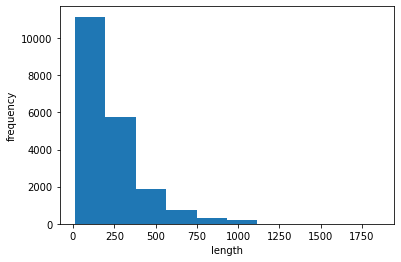

In [ ]:
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

리뷰들의 길이가 제각각이다. 이러한 다양한 길이의 텍스트 데이터의 길이를 맞춰주기 위해 패딩(padding)을 이용한다.

`pad_sequences()`를 사용하면 시퀀스 데이터의 길이를 maxlen에 맞춰 그보다 긴 경우 잘라내고, 짧은 경우 0으로 채운다.

여기서는 100 정도를 사용하겠다.

In [ ]:
train_seq = pad_sequences(X_train, maxlen=100)

In [ ]:
print(train_seq.shape)

(20000, 100)


In [ ]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


앞쪽에 0이 채워져있다. 자르거나 채우는 방향은 pad_sequence()의 padding과 truncating 매개변수로 조절할 수 있다.

In [ ]:
val_seq = pad_sequences(X_val, maxlen=100)

## 순환 신경망 만들기

케라스는 여러 종류의 순환층 클래스를 제공한다. 그중 가장 간단한 것은 SimpleRNN 클래스이다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500))) # 토큰에 대응되는 정수값을 원핫 인코딩으로 만들기 위한 500 길이의 배열
model.add(keras.layers.Dense(1, activation='sigmoid'))

### 원-핫 인코딩 사용하기

In [ ]:
# 원-핫 인코딩
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
val_oh = keras.utils.to_categorical(val_seq)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## 순환 신경망 훈련하기

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, y_train, epochs=100, batch_size=64,
                    validation_data=(val_oh, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 49ms/step - loss: 0.7010 - accuracy: 0.4988 - val_loss: 0.6940 - val_accuracy: 0.5220
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6905 - accuracy: 0.5353 - val_loss: 0.6835 - val_accuracy: 0.5602
Epoch 3/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6791 - accuracy: 0.5770 - val_loss: 0.6744 - val_accuracy: 0.5944
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6690 - accuracy: 0.6043 - val_loss: 0.6654 - val_accuracy: 0.6180
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6574 - accuracy: 0.6300 - val_loss: 0.6539 - val_accuracy: 0.6404
Epoch 6/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6437 - accuracy: 0.6557 - val_loss: 0.6415 - val_accuracy: 0.6564
Epoch 7/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6289 - accuracy: 0.6767 - val_loss: 0.6250 - val_ac

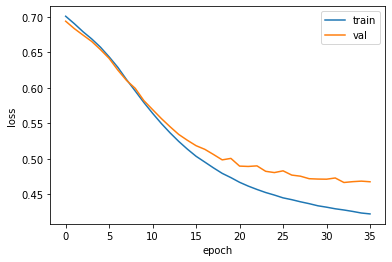

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

원-핫 인코딩의 단점은 입력 데이터가 굉장히 커진다는 점이다. 위에서 길이를 조금만 늘려도 램 사용량 초과가 발생하곤 할 정도이다.

In [ ]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 4000000000


토큰 1개를 500차원으로 늘렸기 때문에 500배가 커졌다.

### 워드 임베딩 사용하기

워드 임베딩(word embedding)은 순환 신경망에서 텍스트를 처리할 때 주로 사용하는 방법이다. 워드 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꿔준다. 이런 방식으로 만들어진 벡터는 원-핫 인코딩 벡터보다 훨씬 의미있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내곤 한다.

워드 임베딩의 장점은 입력으로 정수 데이터를 받는다는 점이다. 즉, 원-핫 인코딩으로 변경된 train_oh 배열이 아니라 train_seq를 바로 사용할 수 있다.

워드 임베딩 또한 2차원 배열로 샘플의 크기를 늘리지만 원-핫 인코딩보다 훨씬 작은 크기로 단어를 표현할 수 있다.

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

Embedding 클래스의 첫 번째 매개변수 500은 단어 사전의 크기이다. 

두 번째 매개변수 16은 임베딩 벡터의 크기이다. 여기에서는 원-핫 인코딩보다 훨씬 작은 크기의 벡터를 사용했다.

세 번째 input_length 매개변수는 입력 시퀀스 train_seq의 길이이다. 

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 25ms/step - loss: 0.6916 - accuracy: 0.5357 - val_loss: 0.6739 - val_accuracy: 0.5948
Epoch 2/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6618 - accuracy: 0.6296 - val_loss: 0.6514 - val_accuracy: 0.6572
Epoch 3/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6356 - accuracy: 0.6876 - val_loss: 0.6332 - val_accuracy: 0.6824
Epoch 4/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6147 - accuracy: 0.7170 - val_loss: 0.6122 - val_accuracy: 0.7232
Epoch 5/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5976 - accuracy: 0.7336 - val_loss: 0.6027 - val_accuracy: 0.7168
Epoch 6/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5821 - accuracy: 0.7464 - val_loss: 0.5862 - val_accuracy: 0.7380
Epoch 7/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5686 - accuracy: 0.7563 - val_loss: 0.5793 - val_accuracy:

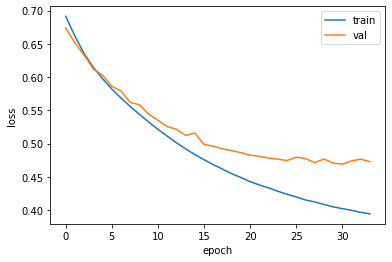

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

계속 감소하는 훈련 손실과 달리 검증 손실이 줄어들지 않아 조기 종료 되었다.